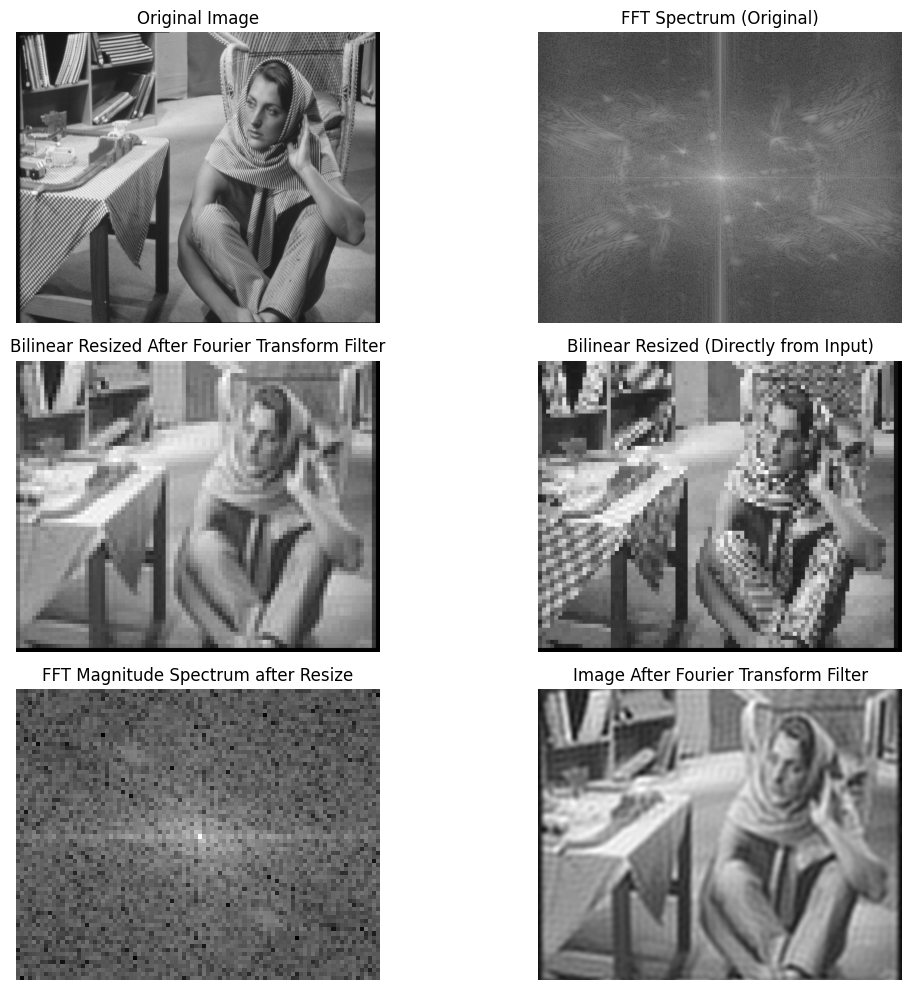

True

In [ ]:
#q1
import cv2 as cv
import sys
import numpy as np
import matplotlib.pyplot as plt
img = cv.imread('/barbara.bmp', cv.IMREAD_GRAYSCALE)
k=0.125
def bilinear_resize(im=img, scale=k):
    h,w=im.shape
    pimg = np.zeros((h+4, w+4))
    pimg[1:h+1, 1:w+1] = im

    pimg[2:h+2, 0:2] = im[:, 0:1]
    pimg[h+2:h+4, 2:w+2] = im[h-1:h, :]
    pimg[2:h+2, w+2:w+4] = im[:, w-1:w]
    pimg[0:2, 2:w+2] = im[0:1, :]

    pimg[0:2, 0:2] = im[0, 0]
    pimg[h+2:h+4, 0:2] = im[h-1, 0]
    pimg[h+2:h+4, w+2:w+4] = im[h-1, w-1]
    pimg[0:2, w+2:w+4] = im[0, w-1]
    new_img=np.array([[0 for i in range(int(w*scale))] for j in range(int(h*scale))], dtype=np.uint8)

    for y in range(int(h*scale)):
        for x in range(int(w*scale)):
            x_new, y_new=x/scale + 2, y/scale + 2
            x1, y1= np.floor(x_new), np.floor(y_new)
            x2, y2=x1+1,y1+1
            dx,dy=x_new-x1, y_new-y1

            # new_img[y][x]=old_img[min(y_new+int(min(new_points_y)), h-1)][min(x_new+int(min(new_points_x)), w-1)]
            val=min(255, pimg[min(h+3, int(y1))][min(w+3, int(x1))]*(1-dx)*(1-dy)+pimg[min(h+3, int(y2))][min(w+3, int(x1))]*dy*(1-dx)+pimg[min(h+3, int(y1))][min(w+3, int(x2))]*dx*(1-dy)+pimg[min(h+3, int(y2))][min(w+3, int(x2))]*dx*dy)
            new_img[y][x] = val

    return new_img
def nearest_neighbour_resize(im=img, scale=0.5):

    mat1=list(np.array(im, dtype=np.uint8))
    h,w=im.shape
    pimg = np.zeros((h+4, w+4))
    pimg[1:h+1, 1:w+1] = im

    pimg[2:h+2, 0:2] = im[:, 0:1]
    pimg[h+2:h+4, 2:w+2] = im[h-1:h, :]
    pimg[2:h+2, w+2:w+4] = im[:, w-1:w]
    pimg[0:2, 2:w+2] = im[0:1, :]

    pimg[0:2, 0:2] = im[0, 0]
    pimg[h+2:h+4, 0:2] = im[h-1, 0]
    pimg[h+2:h+4, w+2:w+4] = im[h-1, w-1]
    pimg[0:2, w+2:w+4] = im[0, w-1]
    new_img=np.array([[0 for i in range(int(w*scale))] for j in range(int(h*scale))], dtype=np.uint8)
    out=[]
    for y in range(int(h*scale)):
        for x in range(int(w*scale)):
            x_new, y_new=x/scale + 2, y/scale + 2

            # new_img[y][x]=old_img[min(y_new+int(min(new_points_y)), h-1)][min(x_new+int(min(new_points_x)), w-1)]
            val=min(255, pimg[min(h+3, int(y_new)), min(w+3, int(x_new))])
            new_img[y][x] = val

    return new_img

def fourier_transform_filter(im, k):
    h,w=im.shape
    F = np.fft.fft2(im)
    F = np.fft.fftshift(F)
    # F=cv.dft(np.float32(im), flags=cv.DFT_COMPLEX_OUTPUT)
    H=np.zeros((h,w))
    dx=1
    dy=1
    f_x_nyq=k/(2*dx)
    f_y_nyq=k/(2*dy)
    F_new=np.zeros(F.shape)
    for nu_y in range(-h//2, h//2):
        for nu_x in range(-w//2, w//2):
            # elliptical
            if (nu_y/(h*f_y_nyq))**2+(nu_x/(w*f_x_nyq))**2<=1:
                H[nu_y+h//2, nu_x+w//2]=1
    F_new=F*H

    im_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(F_new)))
    magnitude = cv.normalize(im_filtered, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
    return magnitude

im_filtered=fourier_transform_filter(img, k)
new_image_bilinear_after_fft=bilinear_resize(im_filtered, k)
new_image_bilinear=bilinear_resize(img, k)
bilinear_fft=cv.dft(np.float32(new_image_bilinear), flags=cv.DFT_COMPLEX_OUTPUT)
fourier_shift = np.fft.fftshift(bilinear_fft)
magnitude = 20*np.log(cv.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))
magnitude = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)

magnitude_orig = 20*np.log(cv.magnitude(np.fft.fftshift(cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT))[:,:,0],np.fft.fftshift(cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT))[:,:,1]))
magnitude_orig = cv.normalize(magnitude_orig, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
cv.waitKey(0)
cv.destroyAllWindows()

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(magnitude_orig, cmap='gray')
axes[0, 1].set_title('FFT Spectrum (Original)')
axes[0, 1].axis('off')

axes[1, 0].imshow(nearest_neighbour_resize(new_image_bilinear_after_fft, 1/k), cmap='gray')
axes[1, 0].set_title('Bilinear Resized After Fourier Transform Filter')
axes[1, 0].axis('off')

axes[1, 1].imshow(nearest_neighbour_resize(new_image_bilinear, 1/k), cmap='gray')
axes[1, 1].set_title('Bilinear Resized (Directly from Input)')
axes[1, 1].axis('off')

axes[2,0].imshow(magnitude, cmap='gray')
axes[2,0].set_title('FFT Magnitude Spectrum after Resize')
axes[2,0].axis('off')
axes[2, 1].imshow(im_filtered, cmap='gray')
axes[2, 1].set_title('Image After Fourier Transform Filter')
axes[2, 1].axis('off')
plt.tight_layout()
plt.show()

cv.waitKey(0)
cv.destroyAllWindows()

cv.imwrite("/img_bilinear_fft.png", magnitude)
cv.imwrite("/img_bilinear_before_fft.png", new_image_bilinear)
cv.imwrite("/img_bilinear_after_fft.png", new_image_bilinear_after_fft)
cv.imwrite("/orig_img_bilinear_before_fft.png", nearest_neighbour_resize(new_image_bilinear, 1/k))
cv.imwrite("/orig_img_bilinear_after_fft.png", nearest_neighbour_resize(new_image_bilinear_after_fft, 1/k))

0.35021864146097537
0.22283373508618512
0.10023862655466376


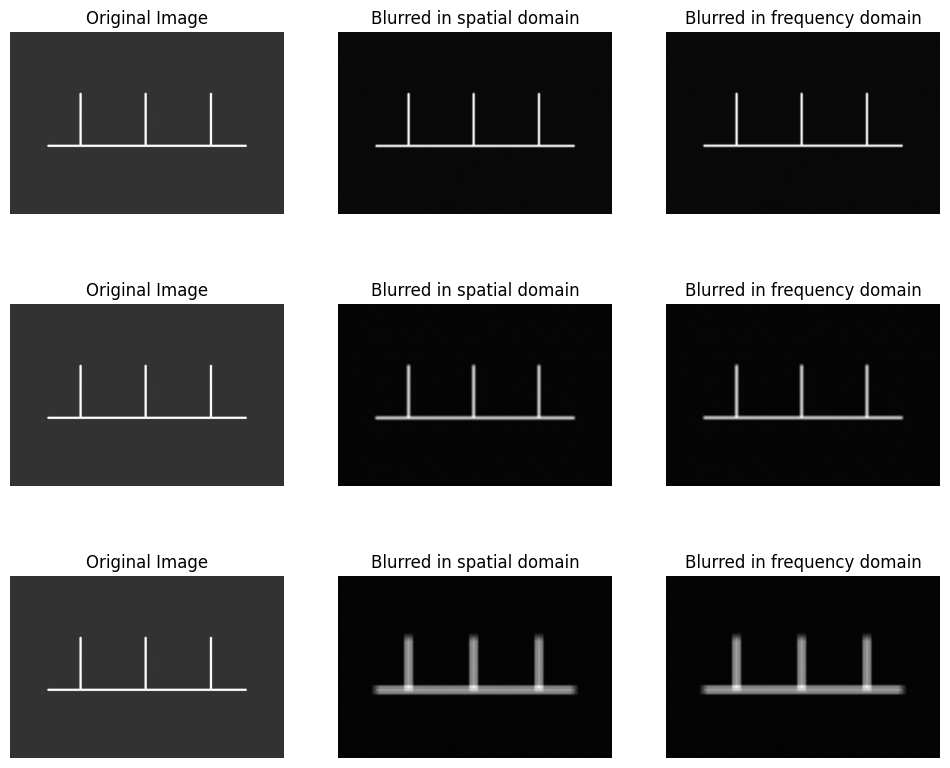

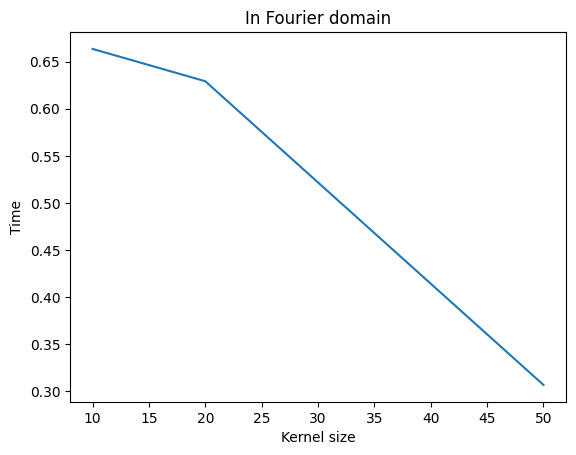

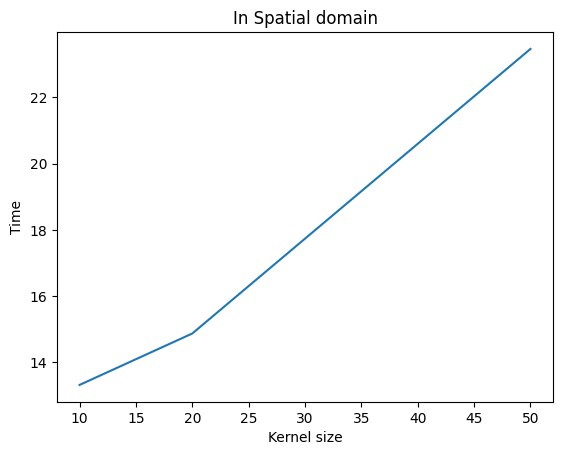

In [ ]:
#q2
import cv2 as cv
import sys
import numpy as np
from scipy.signal import convolve2d
import time
import matplotlib.pyplot as plt

file='img_impulse'
h = cv.imread('/point_image.png', cv.IMREAD_GRAYSCALE)
img=cv.imread(f"/{file}.png", cv.IMREAD_GRAYSCALE)
psf=[10, 20, 50]
def bilinear_resize(im=h, pi=10):
    h,w=im.shape
    scale=pi/h

    new_img=np.array([[0 for i in range(int(w*scale))] for j in range(int(h*scale))], dtype=np.uint8)

    for y in range(int(h*scale)):
        for x in range(int(w*scale)):
            x_new, y_new=x/scale , y/scale
            x1, y1= np.floor(x_new), np.floor(y_new)
            x2, y2=x1+1,y1+1
            dx,dy=x_new-x1, y_new-y1

            # new_img[y][x]=old_img[min(y_new+int(min(new_points_y)), h-1)][min(x_new+int(min(new_points_x)), w-1)]
            val=min(255, im[min(h-1, int(y1))][min(w-1, int(x1))]*(1-dx)*(1-dy)+im[min(h-1, int(y2))][min(w-1, int(x1))]*dy*(1-dx)+im[min(h-1, int(y1))][min(w-1, int(x2))]*dx*(1-dy)+im[min(h-1, int(y2))][min(w-1, int(x2))]*dx*dy)
            new_img[y][x] = val


    return new_img
def fourier_transform_filter(im, pi):

    h,w=im.shape
    F = np.fft.fft2(im)
    F = np.fft.fftshift(F)
    # F=cv.dft(np.float32(im), flags=cv.DFT_COMPLEX_OUTPUT)
    H=np.zeros((h,w))
    k=pi/h
    dx=1
    dy=1
    f_x_nyq=k/(2*dx)
    f_y_nyq=k/(2*dy)
    F_new=np.zeros(F.shape)
    for nu_y in range(-h//2, h//2):
        for nu_x in range(-w//2, w//2):
            # elliptical
            if (nu_y/(h*f_y_nyq))**2+(nu_x/(w*f_x_nyq))**2<=1:
                H[nu_y+h//2, nu_x+w//2]=1
    F_new=F*H

    im_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(F_new)))
    magnitude = cv.normalize(im_filtered, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)


    return magnitude

def convolve(kernel, im):

    b, a=kernel.shape
    h, w=im.shape

    b1, a1 = (b)//2, (a)//2
    new_img=np.zeros((h, w))
    # pimg = np.zeros((h+b-1, w+a-1), dtype=np.float32)
    # pimg[b1:b1+h, a1:a1+w] = im

    # pimg[0:b1, a1:a1+w] = im[b1:0:-1, :]
    # pimg[b1+h:, a1:a1+w] = im[-2:-b1-2:-1, :]

    # pimg[:, 0:a1] = pimg[:, 2*a1:a1:-1]
    # pimg[:, a1+w:] = pimg[:, w+a1-2:w-2:-1]
    kernel = np.flipud(np.fliplr(kernel))
    pimg = np.pad(im,pad_width=((b1, b1), (a1, a1)),mode='reflect')
    # for y in range(b1, h+b1+1):
    #     for x in range(a1, w+a1+1):

    #         # for t in range(-b1, b1+1):
    #         #     for s in range(-a1, a1+1):
    #         #         val+=kernel[t+b1][s+a1]*pimg[y-t][x-s]
    #         window = pimg[y+b1+1:y-b1:-1, x+a1:x-a1:-1]
    #         new_img[y-b1][x-a1]=np.sum(window*kernel)
    for y in range(h):
        for x in range(w):
            window = pimg[y:y+b, x:x+a]
            new_img[y, x] = np.sum(window * kernel)
    return new_img


def fourier_mult(h, im):
    b, a=h.shape
    h1,w1=im.shape
    b1, a1 = (b-1)//2, (a-1)//2
    pimg = np.pad(im,pad_width=((b1, b1), (a1, a1)),mode='reflect')

    F_im = np.fft.fft2(pimg)

    H = np.zeros(pimg.shape)
    kh, kw = h.shape
    cy, cx = kh//2, kw//2
    H[:kh, :kw] = h
    H = np.roll(H, -cy, axis=0)
    H = np.roll(H, -cx, axis=1)
    Hf = np.fft.fft2(H)
    G = F_im*Hf
    blurred_freq = np.real(np.fft.ifft2(G)[b1:h1+b1, a1:a1+w1])
    blurred = cv.normalize(blurred_freq, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)

    return blurred_freq

F_h=np.fft.fft2(h)
F_im=np.fft.fft2(img)

ver_psf=[]
for p in psf:
    im_filtered=fourier_transform_filter(h, p)
    new_image=bilinear_resize(im_filtered, p)
    ver_psf.append(new_image)
psf_versions = [p.astype(np.float32) / np.sum(p) for p in ver_psf]
blurred_versions = []
blurred_versions_F=[]
t_s=[]
t_f=[]
fig, axes = plt.subplots(len(psf_versions), 3, figsize=(12, 10))

for i, p in enumerate(psf_versions):
    start_time_1= time.perf_counter()
    blurred_F=fourier_mult(p,img)
    end_time_1=time.perf_counter()
    t_f.append(end_time_1-start_time_1)
    start_time_2 = time.perf_counter()
    blurred = convolve(p, img)
    end_time_2=time.perf_counter()
    t_s.append(end_time_2-start_time_2)

    blurred_versions.append(blurred)
    blurred_versions_F.append(blurred_F)
    cv.waitKey(0)
    cv.destroyAllWindows()
    cv.imwrite(f"/{file}_img_psf_{i+1}.png", blurred)
    cv.imwrite(f"/{file}_orig_img_psf_fourier_mult_{i+1}.png", blurred_F)
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(blurred, cmap='gray')
    axes[i, 1].set_title('Blurred in spatial domain')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(blurred_F, cmap='gray')
    axes[i, 2].set_title('Blurred in frequency domain')
    axes[i, 2].axis('off')

    diff = np.abs(blurred - blurred_F)
    print(np.mean(diff))
plt.show()
plt.title("In Fourier domain")
plt.plot(psf, t_f)
plt.xlabel('Kernel size')
plt.ylabel('Time')
plt.show()
plt.title("In Spatial domain")
plt.plot(psf, t_s)
plt.xlabel('Kernel size')
plt.ylabel('Time')
plt.show()

image shape: (748, 493)


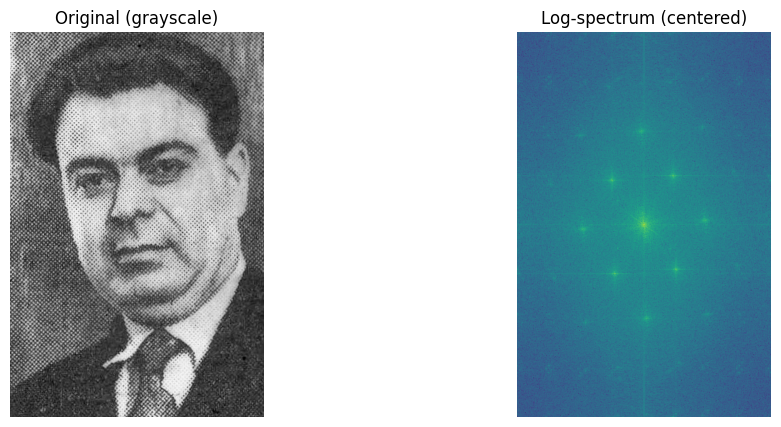

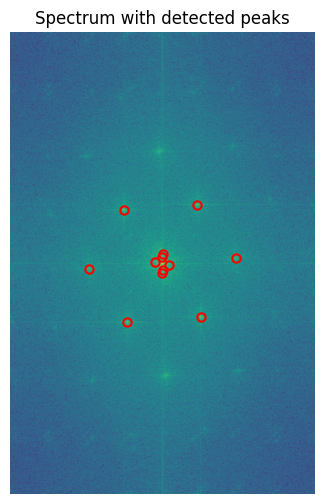

Detected peak coords (row,col), relative (dy,dx), distance r, spatial period T (pixels):
(np.int64(287), np.int64(184))  -> (dy,dx)=(-87.0,-62.0), r=106.83, T≈7.00 px
(np.int64(461), np.int64(308))  -> (dy,dx)=(87.0,62.0), r=106.83, T≈7.00 px
(np.int64(279), np.int64(303))  -> (dy,dx)=(-95.0,57.0), r=110.79, T≈6.75 px
(np.int64(469), np.int64(189))  -> (dy,dx)=(95.0,-57.0), r=110.79, T≈6.75 px
(np.int64(363), np.int64(245))  -> (dy,dx)=(-11.0,-1.0), r=11.05, T≈67.72 px
(np.int64(385), np.int64(247))  -> (dy,dx)=(11.0,1.0), r=11.05, T≈67.72 px
(np.int64(372), np.int64(235))  -> (dy,dx)=(-2.0,-11.0), r=11.18, T≈66.90 px
(np.int64(376), np.int64(257))  -> (dy,dx)=(2.0,11.0), r=11.18, T≈66.90 px
(np.int64(359), np.int64(247))  -> (dy,dx)=(-15.0,1.0), r=15.03, T≈49.76 px
(np.int64(389), np.int64(245))  -> (dy,dx)=(15.0,-1.0), r=15.03, T≈49.76 px
(np.int64(365), np.int64(365))  -> (dy,dx)=(-9.0,119.0), r=119.34, T≈6.27 px
(np.int64(383), np.int64(127))  -> (dy,dx)=(9.0,-119.0), r=119.34, T≈6

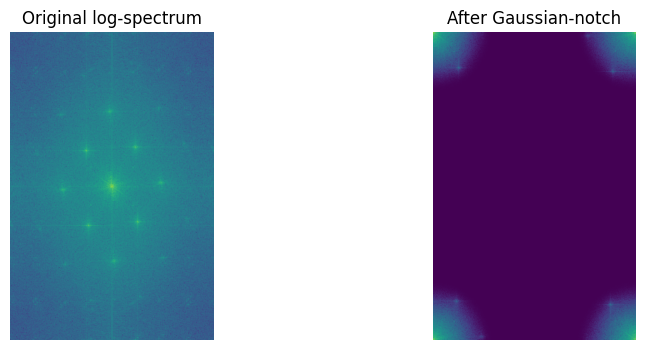

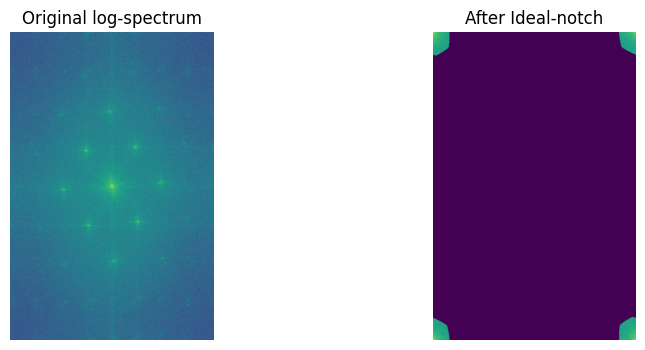

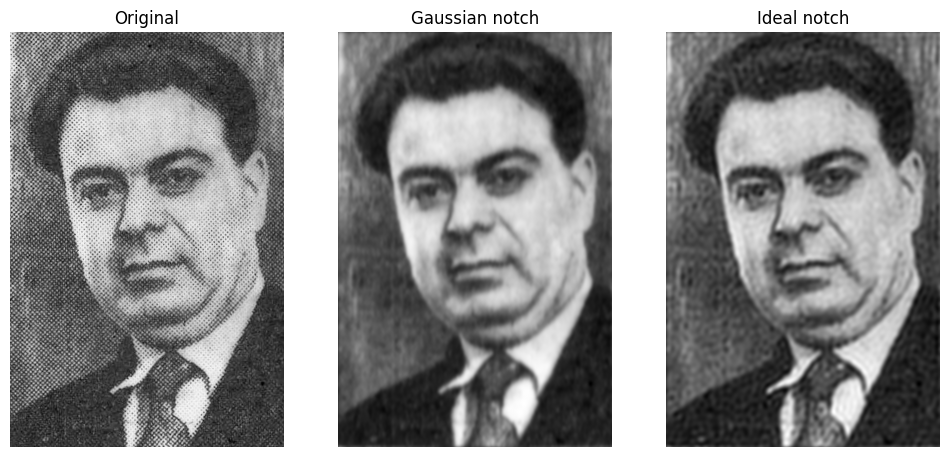

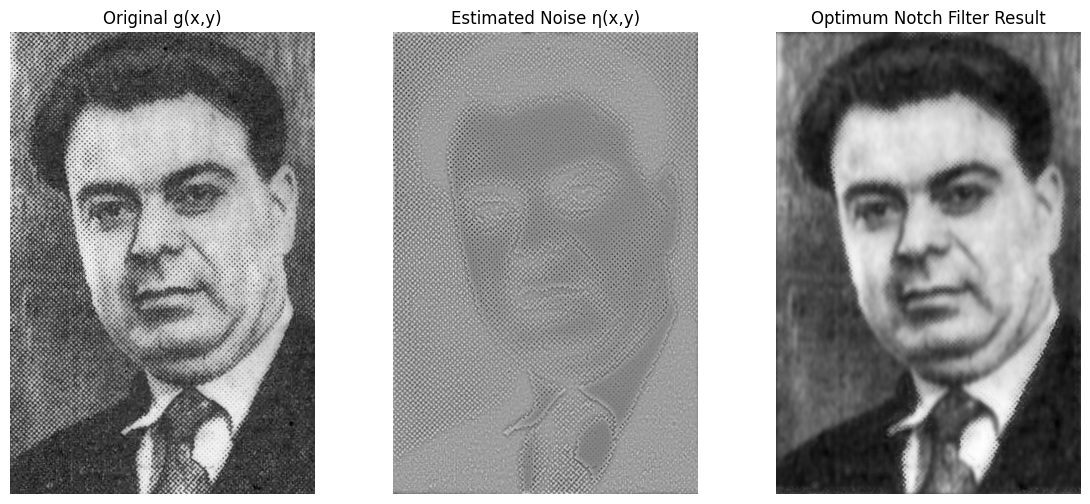

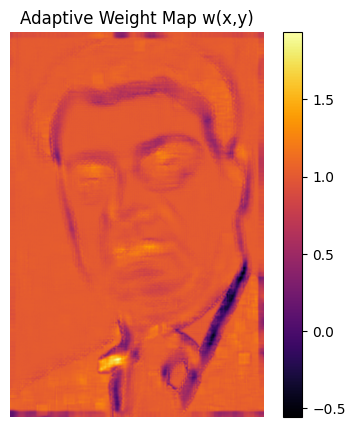

cov(g,η): min=-0.0029, max=0.0559
var(η):   min=0.0005, max=0.0569
w:        mean=0.9564, min=-0.5564, max=1.9355


In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import convolve

def imshow_gray(img, title="", cmap="gray"):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')


def log_spectrum(F):
    
    mag = np.abs(F)
    return np.log1p(mag)


img_path = "img.jpg"
I_color = cv.imread(img_path, cv.IMREAD_UNCHANGED)

# grayscale
if len(I_color.shape) == 3:
    I = cv.cvtColor(I_color, cv.COLOR_BGR2GRAY).astype(np.float32)
else:
    I = I_color.astype(np.float32)


h, w = I.shape
print("image shape:", I.shape)

F = np.fft.fft2(I)               # 2D FFT
Fshift = np.fft.fftshift(F)      # center DC
Slog = log_spectrum(Fshift)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(I, cmap='gray')
plt.title("Original (grayscale)")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(Slog, cmap='viridis')
plt.title("Log-spectrum (centered)")
plt.axis('off')
plt.show()

mag = np.abs(Fshift)
center = (h//2, w//2)
mag_no_dc = mag.copy()

dc_radius = 10
yy, xx = np.ogrid[:h, :w]
mask_center = (yy - center[0])**2 + (xx - center[1])**2 <= dc_radius**2
mag_no_dc[mask_center] = 0

neighborhood = 7
local_max = ndimage.maximum_filter(mag_no_dc, size=neighborhood) == mag_no_dc
threshold = np.percentile(mag_no_dc[local_max], 99)  
candidates = np.argwhere(local_max & (mag_no_dc > threshold))

candidates = sorted(candidates, key=lambda p: -mag_no_dc[p[0], p[1]])

topk = 12
peaks = candidates[:topk]

plt.figure(figsize=(6,6))
plt.imshow(Slog, cmap='viridis'); plt.title("Spectrum with detected peaks")
plt.axis('off')
# mark peaks
for (r,c) in peaks:
    plt.plot(c, r, 'ro', markersize=6, markerfacecolor='none', markeredgewidth=1.5)
plt.show()

print("Detected peak coords (row,col), relative (dy,dx), distance r, spatial period T (pixels):")
for (r,c) in peaks:
    dy = r - center[0]
    dx = c - center[1]
    rdist = np.hypot(dy, dx)
    if rdist == 0:
        continue
 
    f = rdist / max(h,w)  
   
    T = max(h,w) / rdist
    print((r,c), " -> (dy,dx)=({:.1f},{:.1f}), r={:.2f}, T≈{:.2f} px".format(dy, dx, rdist, T))


# def convolve(kernel, im):

#     b, a=kernel.shape
#     h, w=im.shape

#     b1, a1 = (b)//2, (a)//2
#     new_img=np.zeros((h, w))

#     kernel = np.flipud(np.fliplr(kernel))
#     pimg = np.pad(im,pad_width=((b1, b1), (a1, a1)),mode='reflect')

#     for y in range(h):
#         for x in range(w):
#             window = pimg[y:y+b, x:x+a]
#             new_img[y, x] = np.sum(window * kernel)
#     return new_img
# ---------- build notch filter helpers ----------
def gaussian_notch_reject(shape, centers, D0):
    """Return a notch-reject multiplicative mask (values in [0,1]) with Gaussian dips at centers.
       shape = (h,w), centers list of (r,c) coords in FFT-shifted coordinates (indices),
       sigma in pixels (radius of notch).
       The returned mask multiplies the shifted FFT (FFT is with np.fft.fftshift).
    """
    h, w = shape
    yy, xx = np.ogrid[:h, :w]
    H = np.ones((h,w), dtype=np.float32)
    for (r0, c0) in centers:
        # dip at (r0,c0) and its conjugate symmetric location about center
        D2 = (yy - r0)**2 + (xx - c0)**2
        H *= (np.exp(-D2 / (2 * (D0**2))))
        # symmetric
        r_sym = h - r0
        c_sym = w - c0
        D2s = (yy - r_sym)**2 + (xx - c_sym)**2
        H *= (np.exp(-D2s / (2 * (D0**2))))
    return np.fft.fftshift(H)


def ideal_notch_reject(shape, centers, radius):
    h,w = shape
    yy, xx = np.ogrid[:h, :w]
    H = np.ones((h,w), dtype=np.float32)
    for (r0,c0) in centers:
        D2 = (yy - r0)**2 + (xx - c0)**2
        H[D2 >= radius**2] = 0

    return np.fft.fftshift(H)


def butterworth_notch_reject(shape, centers, D0, n=2):
    h,w = shape
    yy, xx = np.ogrid[:h, :w]
    H = np.ones((h,w), dtype=np.float32)
    for (r0,c0) in centers:
        Dk = np.sqrt((yy - r0)**2 + (xx - c0)**2)
        Dks = np.sqrt((yy - (h-r0))**2 + (xx - (w-c0))**2)
        # Butterworth notch reject: H = 1 / (1 + (D0 / Dk)^(2n))
        H *= 1.0 / (1.0 + (D0 / (Dk + 1e-9))**(2*n))
        H *= 1.0 / (1.0 + (D0 / (Dks + 1e-9))**(2*n))
    return H

def optimum_notch_reject(F, H_notch, g, win_size=21):
    """
    Implements optimum notch reject filtering (Gonzalez & Woods, 4th Ed.).

    Args:
        Fshift : shifted FFT of the image (np.fft.fftshift)
        H_notch : notch filter mask (same shape as Fshift) used in part (b)
        g : original grayscale image (float)
        win_size : local window size for statistics (should span a few dot periods)

    Returns:
        f_opt_norm : final optimum filtered image (normalized)
        eta_disp   : estimated periodic noise (normalized)
        w          : adaptive weight map
        cov_g_eta, var_eta : intermediate stats (for reporting)
    """

    # 1. Inverse FFT -> periodic noise estimate η(x,y)

    G2 = F * H_notch
    g2 = np.real(np.fft.ifft2(G2))
    g2_norm = (g2 - g2.min())/(g2.max()-g2.min())
    g_norm=(g - g.min())/(g.max()-g.min())
    eta=g-g2
    # eta_disp = (eta - eta.min()) / (eta.max() - eta.min())
    eta_disp=g_norm-g2_norm
    # 2. Compute local means and variances
    kernel = np.ones((win_size, win_size), dtype=np.float32) / (win_size ** 2)
    E_eta = convolve(eta_disp, kernel, mode='reflect')
    E_g = convolve(g_norm, kernel, mode='reflect')
    E_g_eta = convolve(g_norm * eta_disp, kernel, mode='reflect')
    E_eta2 = convolve(eta_disp ** 2, kernel, mode='reflect')

    var_eta = E_eta2 - E_eta ** 2
    cov_g_eta = E_g_eta - (E_g * E_eta)

    # 3. Compute adaptive weight map

    w = cov_g_eta / var_eta
    w = np.clip(w, -3.0, 3.0)

    # 4. Compute optimum filtered image
    f_opt = (g_norm - w*eta_disp)*255
    f_opt_norm = (f_opt - f_opt.min()) / (f_opt.max() - f_opt.min())

    return f_opt_norm, eta_disp, w, cov_g_eta, var_eta


selected_peaks = []
for (r,c) in peaks:
    if np.hypot(r, c) > dc_radius:
        selected_peaks.append((int(r), int(c)))

print("selected peaks:", selected_peaks)

sigma = 160.0  
H_gauss = gaussian_notch_reject(Fshift.shape, selected_peaks, sigma)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(np.log1p(np.abs(Fshift)), cmap='viridis'); plt.title("Original log-spectrum")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.log1p(np.abs(F * H_gauss)), cmap='viridis'); plt.title("After Gaussian-notch")
plt.axis('off')
plt.show()

# apply and invert
G = F * H_gauss
g = np.real(np.fft.ifft2(G))  # shift back before inverse
g_norm = (g - g.min())/(g.max()-g.min())

# ---------- Ideal notch example (same width) ----------
radius = 160  # use similar radius for comparison
H_ideal = ideal_notch_reject(F.shape, selected_peaks, radius)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(np.log1p(np.abs(Fshift)), cmap='viridis'); plt.title("Original log-spectrum")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.log1p(np.abs(F * H_ideal)), cmap='viridis'); plt.title("After Ideal-notch")
plt.axis('off')
plt.show()

G2 = F * H_ideal
g2 = np.real(np.fft.ifft2(G2))
g2_norm = (g2 - g2.min())/(g2.max()-g2.min())

# ---------- compare side-by-side ----------
plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.imshow(I, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(g_norm, cmap='gray'); plt.title("Gaussian notch"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(g2_norm, cmap='gray'); plt.title("Ideal notch"); plt.axis('off')
plt.show()

f_opt_norm, eta_disp, w, cov_g_eta, var_eta = optimum_notch_reject(F, H_gauss, I, win_size=21)

plt.figure(figsize=(14,6))
plt.subplot(1,3,1); plt.imshow(I, cmap='gray'); plt.title("Original g(x,y)"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(eta_disp, cmap='gray'); plt.title("Estimated Noise η(x,y)"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(f_opt_norm, cmap='gray'); plt.title("Optimum Notch Filter Result"); plt.axis('off')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(w, cmap='inferno'); plt.title("Adaptive Weight Map w(x,y)"); plt.colorbar(); plt.axis('off')
plt.show()

print(f"cov(g,η): min={cov_g_eta.min():.4f}, max={cov_g_eta.max():.4f}")
print(f"var(η):   min={var_eta.min():.4f}, max={var_eta.max():.4f}")
print(f"w:        mean={w.mean():.4f}, min={w.min():.4f}, max={w.max():.4f}")



constant - uniform noisy PSNR: 20.01 dB


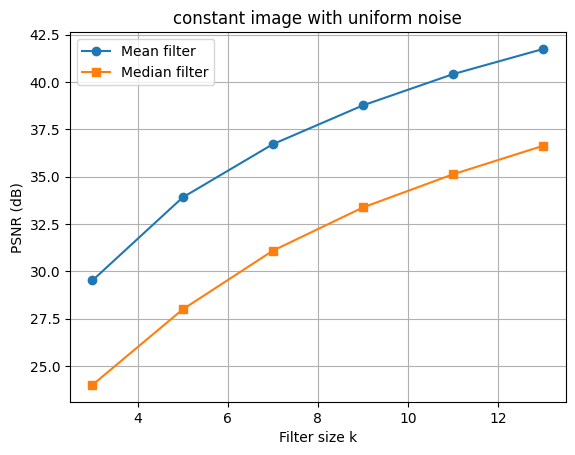

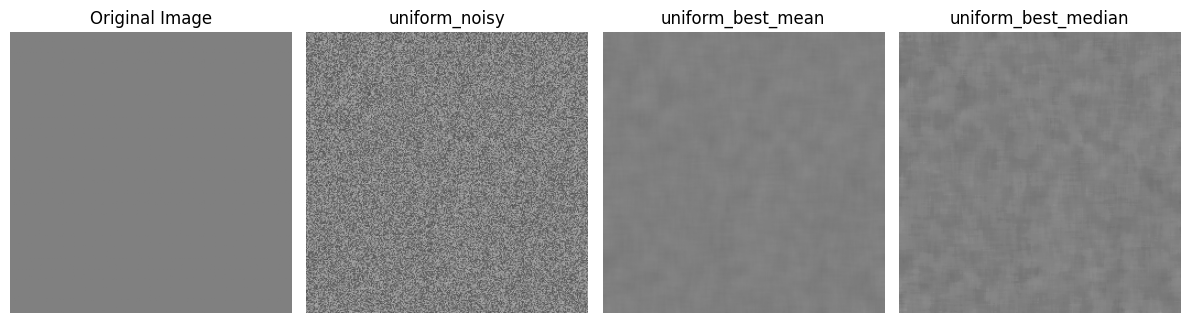

constant - gaussian noisy PSNR: 20.00 dB


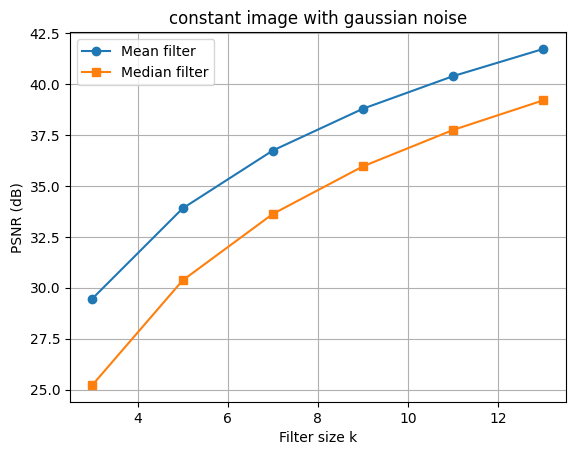

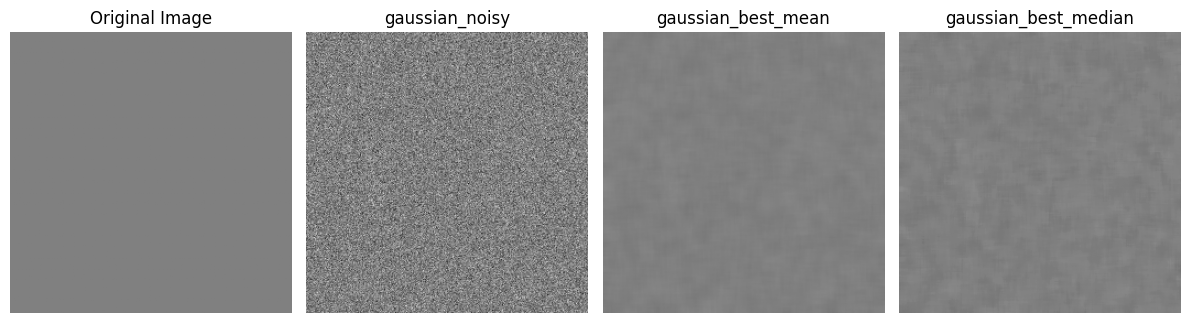

constant - s&p noisy PSNR: 22.88 dB


/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


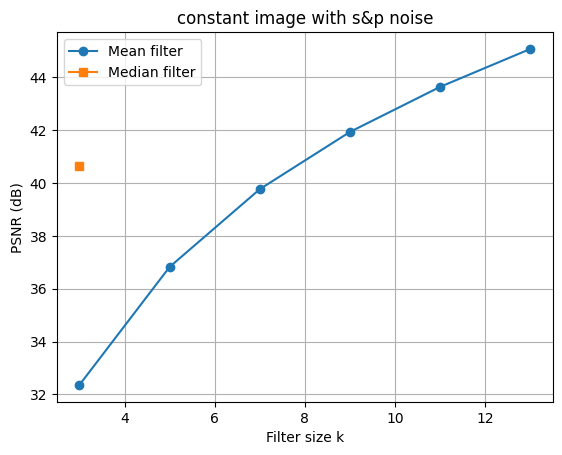

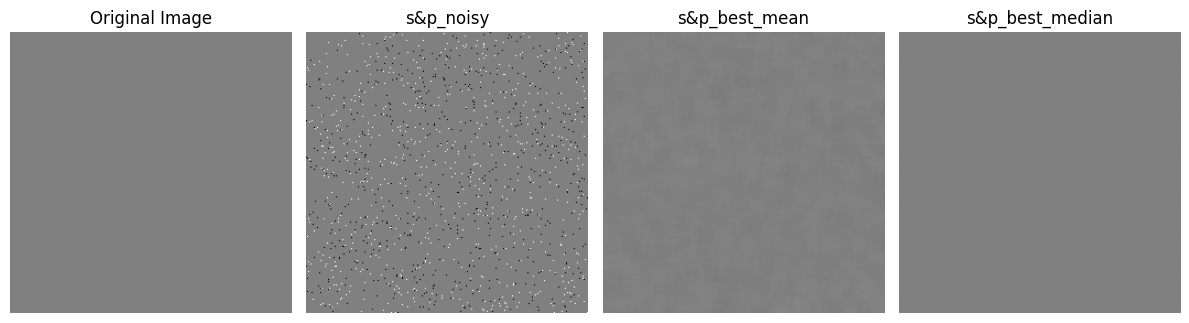

natural - uniform noisy PSNR: 17.04 dB


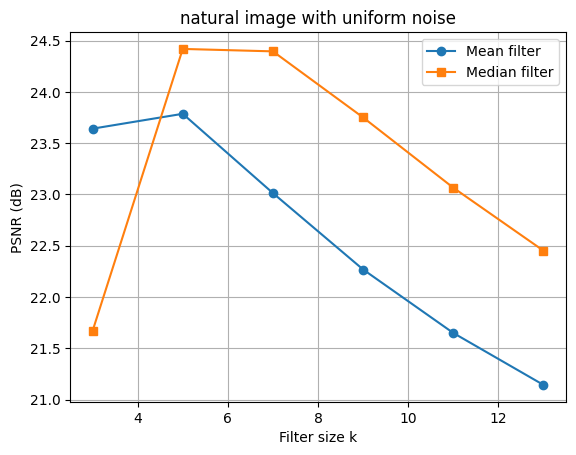

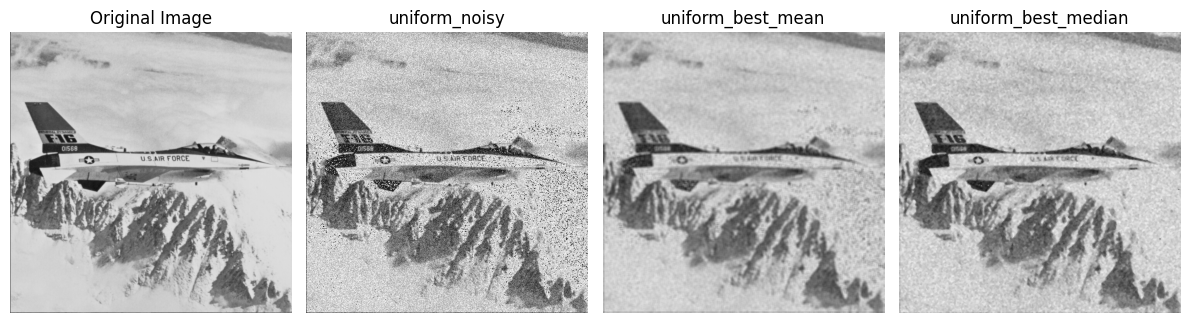

natural - gaussian noisy PSNR: 16.07 dB


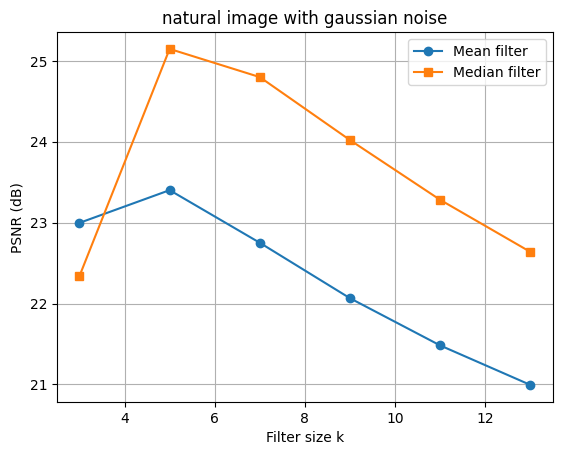

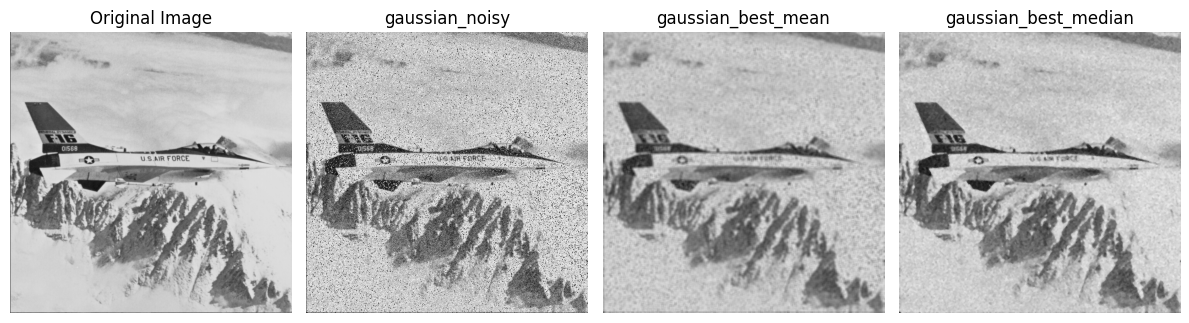

natural - s&p noisy PSNR: 21.78 dB


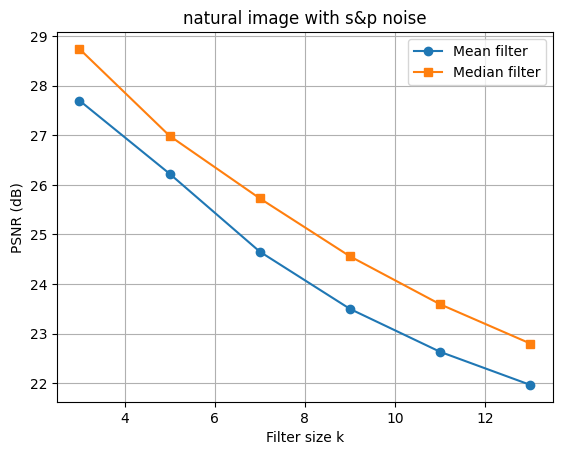

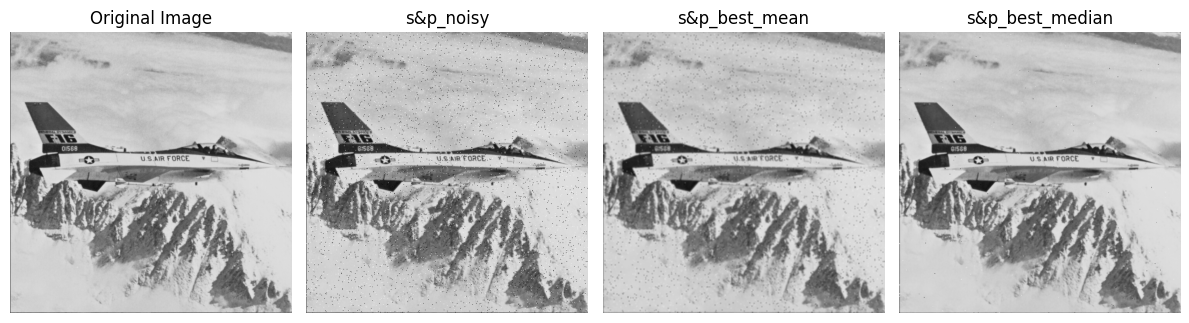

In [ ]:


import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

def add_uniform_noise(img, target_psnr=20):
    h, w = img.shape
    img = img.astype(np.float32)

    # compute required variance from target PSNR
    mse_target = (255 ** 2) / (10 ** (target_psnr / 10))
    noise_var = mse_target
    a = np.sqrt(3 * noise_var)  # uniform [-a,a] variance = a^2/3

    noise = np.random.uniform(-a, a, size=(h, w))
    noisy = img+noise
    return noisy.astype(np.uint8)

def add_gaussian_noise(img, target_psnr=20):
    h, w = img.shape
    img = img.astype(np.float32)

    mse_target = (255 ** 2) / (10 ** (target_psnr / 10))
    sigma = np.sqrt(mse_target)

    noise = np.random.normal(0, sigma, size=(h, w))
    noisy = img+noise
    return noisy.astype(np.uint8)

def add_salt_pepper_noise(img, target_psnr=20):
    h, w = img.shape[:2]
    img = img.astype(np.uint8)

    mse_target = (255 ** 2) / (10 ** (target_psnr / 10))
    p = (2 * mse_target) / (255 ** 2)
    p = np.clip(p, 0, 1)

    noisy = img.copy()
    mask = np.random.rand(h, w)

    pepper = mask < (p / 2)
    salt = (mask >= (p / 2)) & (mask < p)

    noisy[pepper] = 0
    noisy[salt] = 255

    return noisy

def convolve(kernel, im):

    b, a=kernel.shape
    h, w=im.shape

    b1, a1 = (b)//2, (a)//2
    new_img=np.zeros((h, w))

    kernel = np.flipud(np.fliplr(kernel))
    pimg = np.pad(im,pad_width=((b1, b1), (a1, a1)),mode='reflect')

    for y in range(h):
        for x in range(w):
            window = pimg[y:y+b, x:x+a]
            new_img[y, x] = np.sum(window * kernel)
    return new_img

def mean_filter(img, k):
    h,w=img.shape
    kernel=np.ones((k,k), dtype=np.uint8) / (k**2)

    return convolve(kernel, img)

def median_filter(img, k):
    h,w=img.shape
    new_img=np.zeros((h, w))
    pimg=np.pad(img,pad_width=((k//2, k//2), (k//2, k//2)),mode='reflect')
    for y in range(k//2, h+k//2):
        for x in range(k//2, w+k//2):
            window = pimg[y-k//2:y+k//2, x-k//2:x+k//2]
            new_img[y-k//2, x-k//2] = np.median(window)
    return new_img

def experiment(im, name="natural"):

    noises = {
        "uniform": add_uniform_noise,
        "gaussian": add_gaussian_noise,
        "s&p": add_salt_pepper_noise,
    }
    k_values = [3, 5, 7, 9, 11, 13]
    i=0
    for noise_name, noise_fn in noises.items():

        noisy = noise_fn(im, target_psnr=20)
        noisy_psnr = psnr(im, noisy, data_range=255)
        print(f"{name} - {noise_name} noisy PSNR: {noisy_psnr:.2f} dB")

        mean_psnrs = []
        median_psnrs = []
        best_mean, best_median = (0, None), (0, None)

        for k in k_values:
            den_mean = mean_filter(noisy, k)
            den_median = median_filter(noisy, k)

            psnr_mean = psnr(im, den_mean, data_range=255)
            psnr_median = psnr(im, den_median, data_range=255)

            mean_psnrs.append(psnr_mean)
            median_psnrs.append(psnr_median)

            if psnr_mean > best_mean[0]:
                best_mean = (psnr_mean, den_mean)
            if psnr_median > best_median[0]:
                best_median = (psnr_median, den_median)

        plt.figure()
        plt.plot(k_values, mean_psnrs, 'o-', label="Mean filter")
        plt.plot(k_values, median_psnrs, 's-', label="Median filter")
        plt.xlabel("Filter size k")
        plt.ylabel("PSNR (dB)")
        plt.title(f"{name} image with {noise_name} noise")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{name}_{noise_name}_psnr_curve.png")
        plt.show()
        fig, axes = plt.subplots(1, 4, figsize=(12, 10))
        axes[0].imshow(im, cmap='gray', vmin=0, vmax=255)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(noisy, cmap='gray', vmin=0, vmax=255)
        axes[1].set_title(f'{noise_name}_noisy')
        axes[1].axis('off')

        axes[2].imshow(best_mean[1], cmap='gray', vmin=0, vmax=255)
        axes[2].set_title(f'{noise_name}_best_mean')
        axes[2].axis('off')

        axes[3].imshow(best_median[1], cmap='gray', vmin=0, vmax=255)
        axes[3].set_title(f'{noise_name}_best_median')
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

        # save best results
        cv.imwrite(f"/{name}_{noise_name}_best_mean.png", best_mean[1])
        cv.imwrite(f"/{name}_{noise_name}_best_median.png", best_median[1])
        cv.imwrite(f"/{name}_{noise_name}_noisy.png", noisy)


if __name__ == "__main__":
    
    const_img = np.ones((256,256), dtype=np.uint8)*128
    experiment(const_img, "constant")

    img = cv.imread("/airplane.tif", cv.IMREAD_GRAYSCALE)  
    experiment(img, "natural")



Degraded PSNR (w.r.t. blurred_large): 20.079047152827222
Showing low-pass images L_i (degraded g):


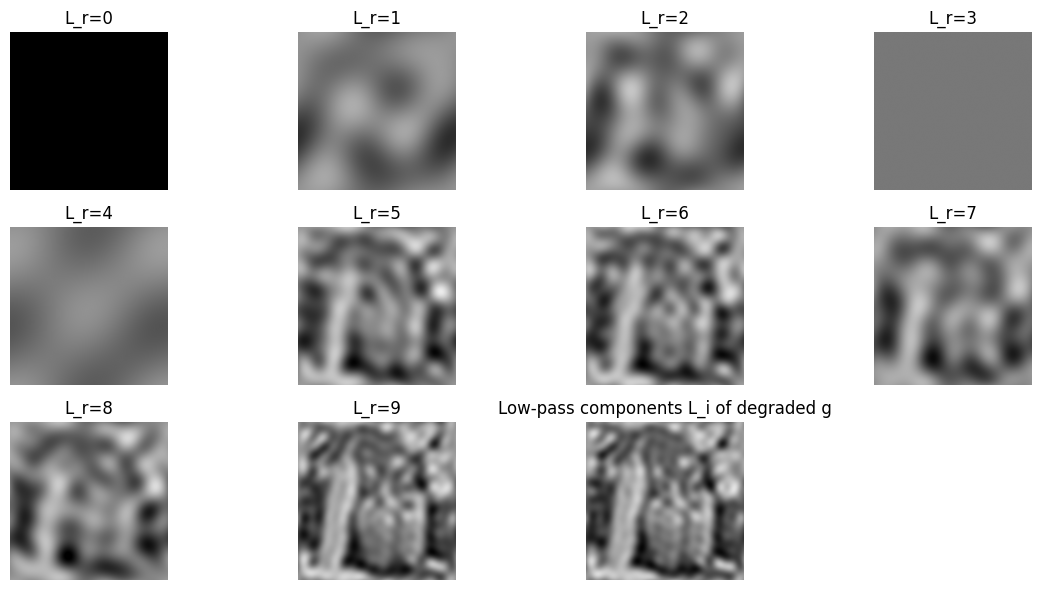

Showing band-pass images l_i = L_i - L_{i-1} (degraded g) with +128 added:


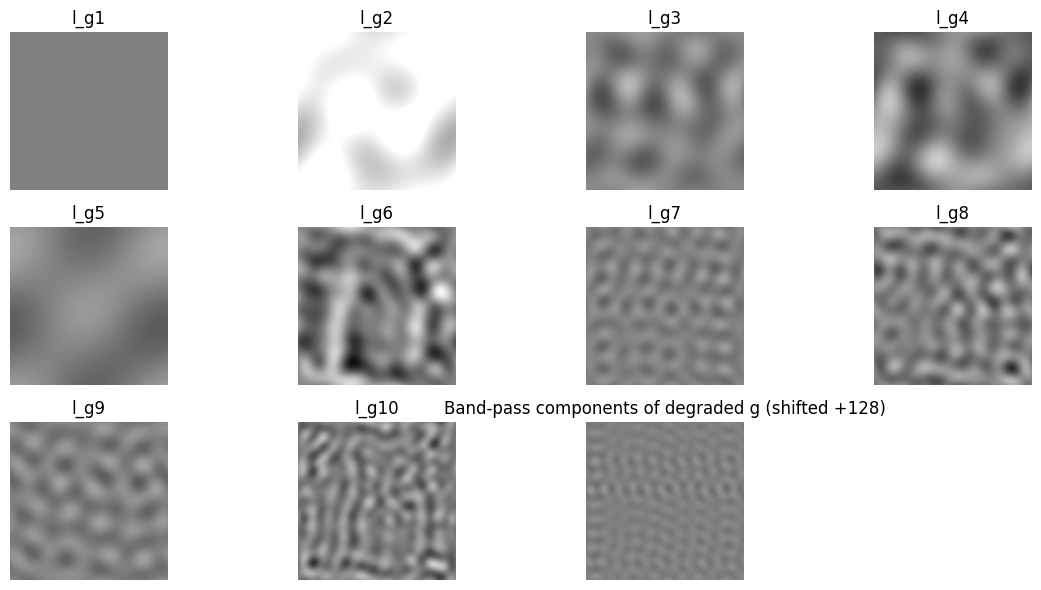

Showing low-pass images L_i of blurred (clean) f:


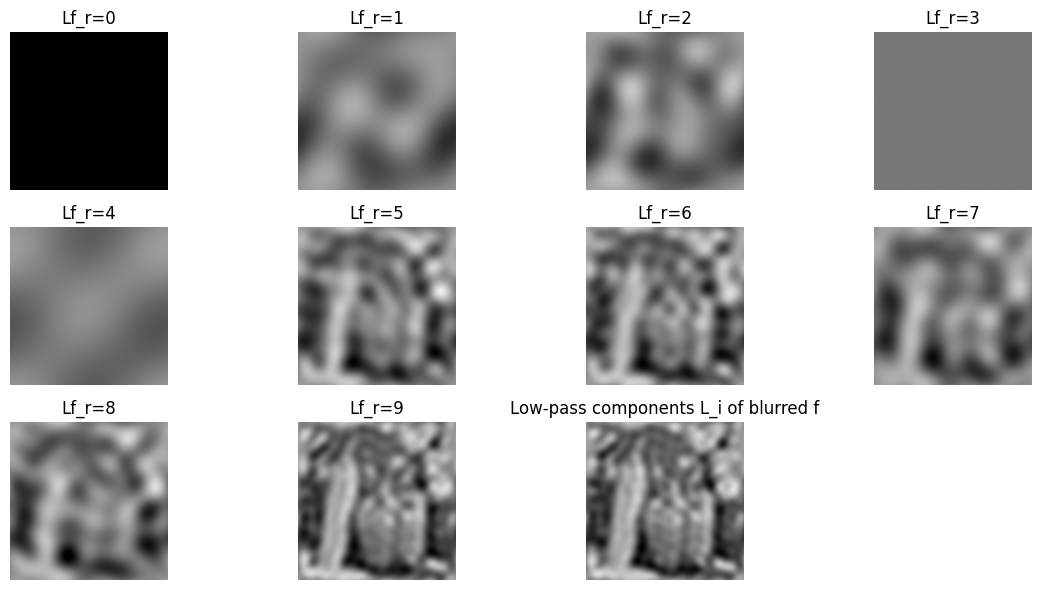

Showing band-pass images l_i of blurred (clean) f (with +128):


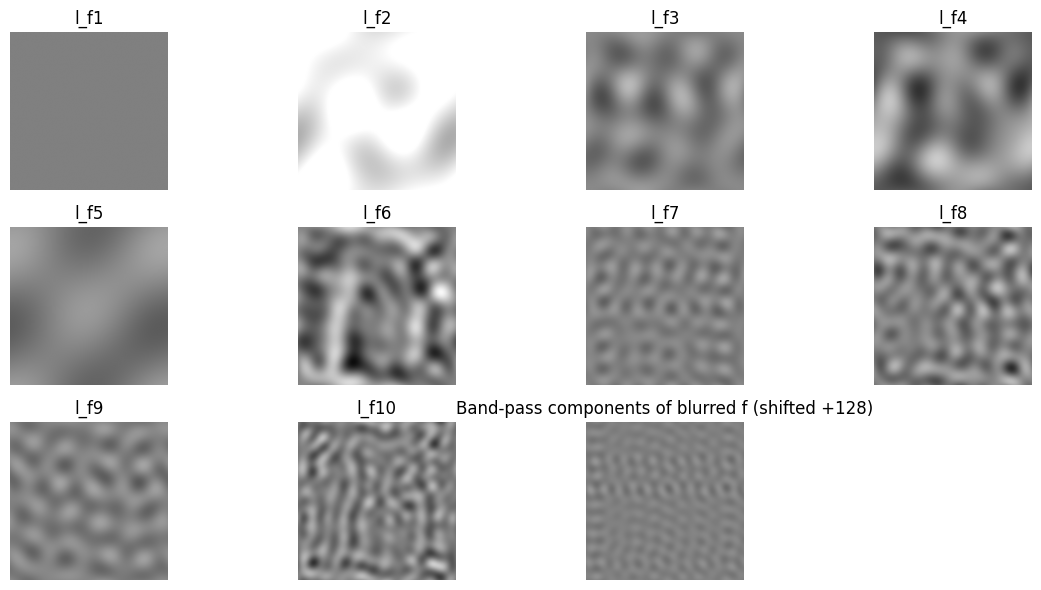

PSNR of naive inverse filter reconstruction w.r.t. blurred (clean) f: 16.337114561917364
Band-pass of inverse restored image (with +128):


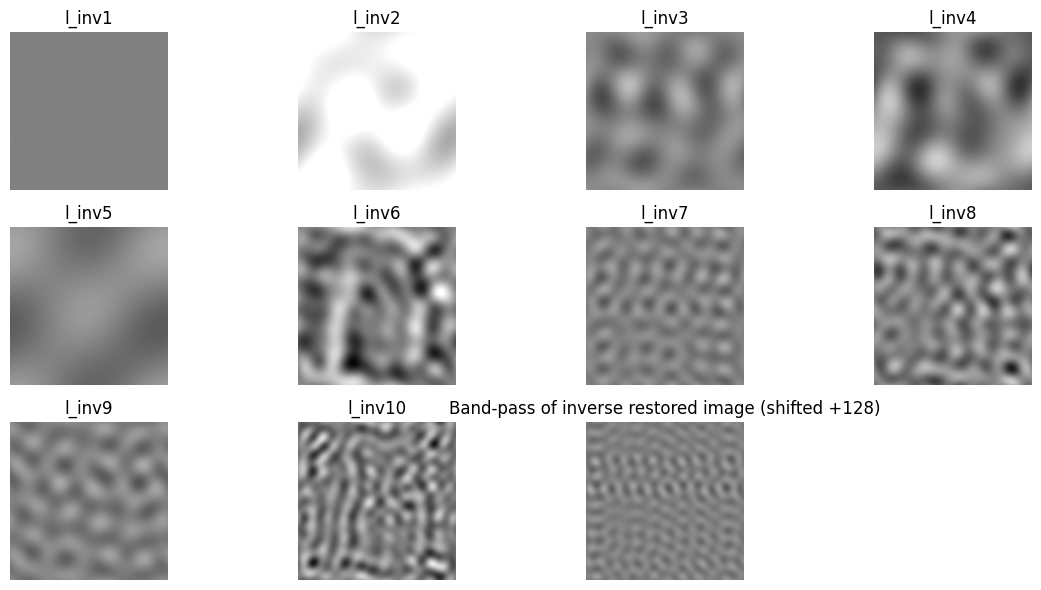

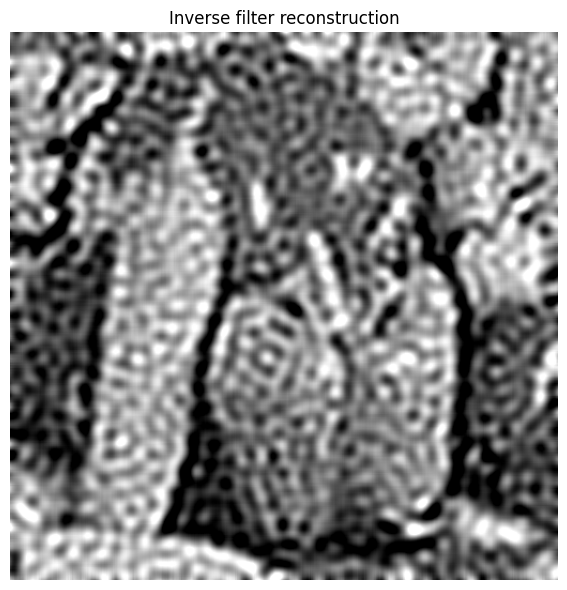

Estimated sigma_n^2 = 649.2783, sigma_f^2 = 2147.2844, K_est = 3.023718e-01


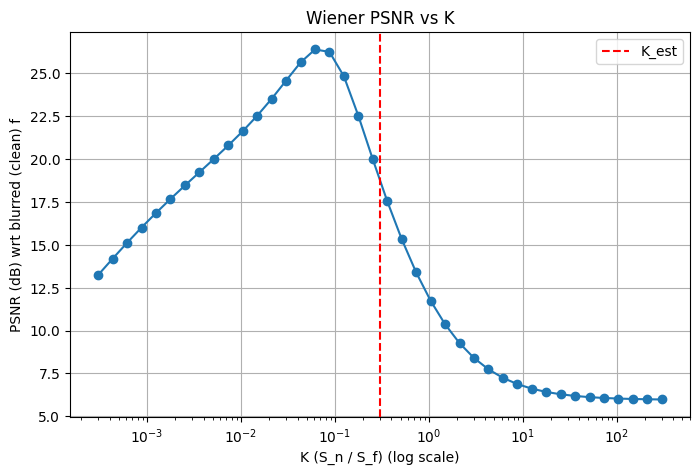

Best K: 0.061409213 Best PSNR: 26.39788722041959


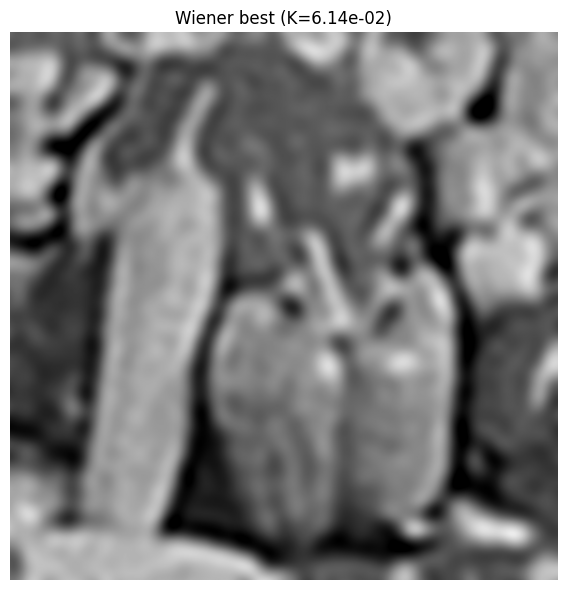

Best lambda: 14.251026703029993 Best PSNR: 34.168584884378475


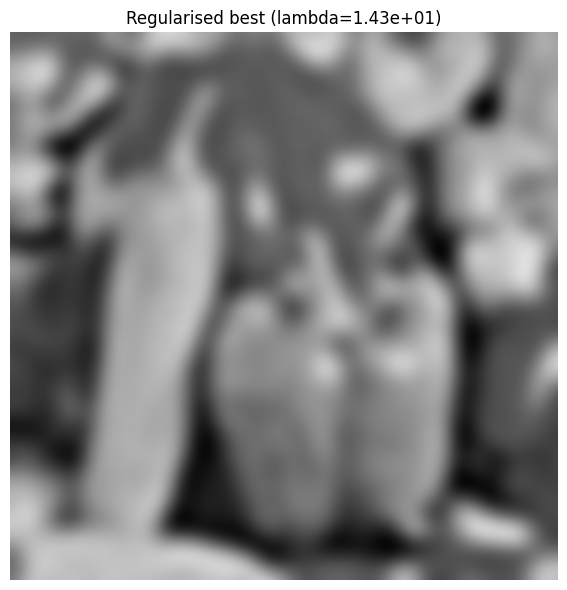

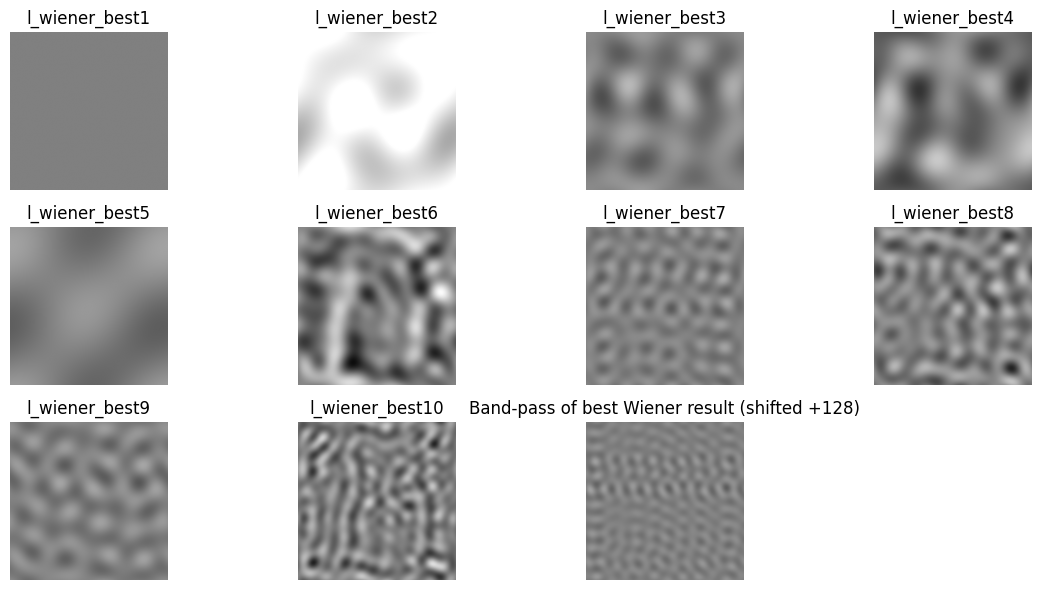

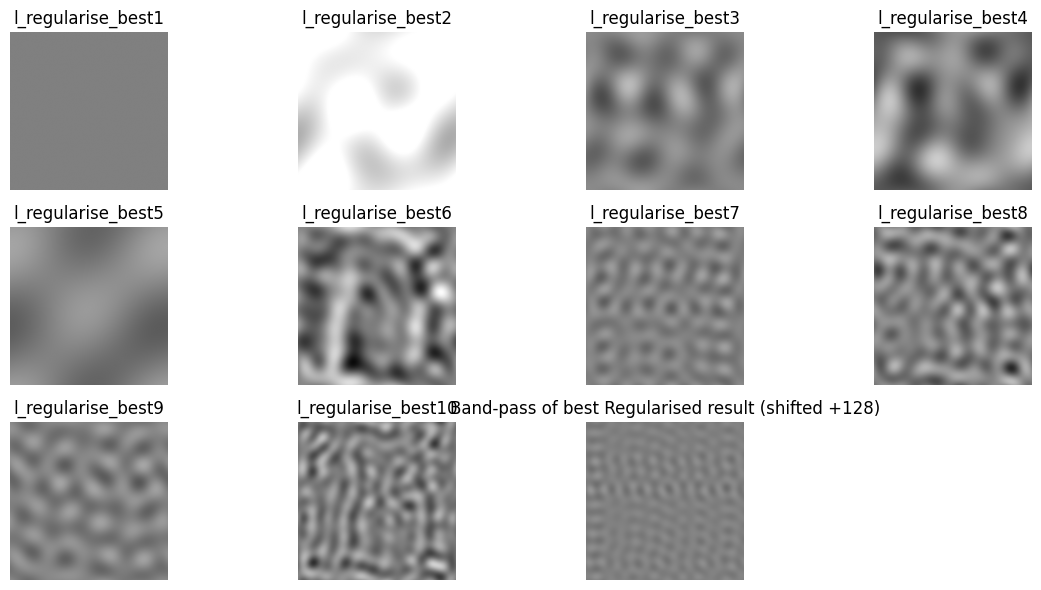


Target PSNR 30.0 dB: sigma_n2=65.0884, K_est=3.0312e-02
 PSNR sweep best K=6.19e-02, best PSNR=26.695 dB


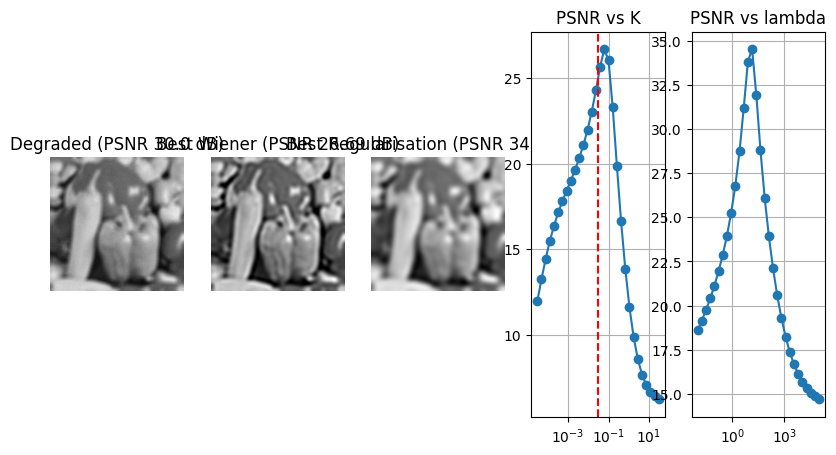


Target PSNR 10.0 dB: sigma_n2=6509.0078, K_est=3.0313e+00
 PSNR sweep best K=8.51e-02, best PSNR=24.817 dB


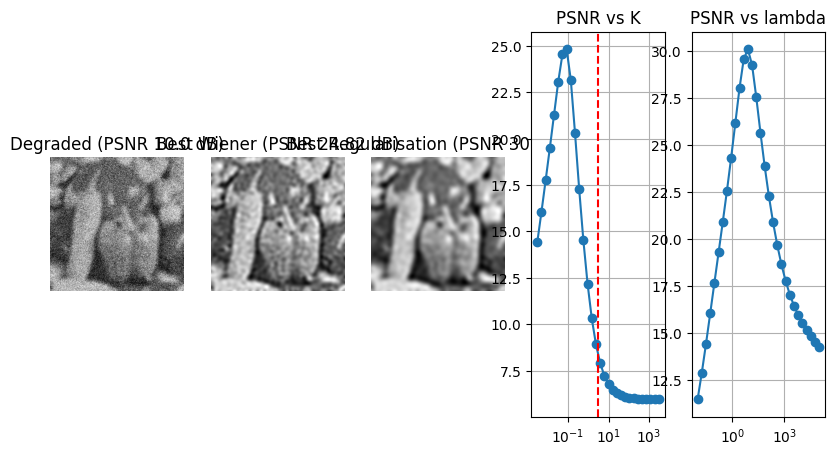

In [ ]:
#q5

# deconv_experiment.py
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy import ndimage

def imshow_grid(imgs, titles=None, cmap='gray', figsize=(12,6)):
    n = len(imgs)
    cols = min(4, n)
    rows = (n + cols - 1)//cols
    plt.figure(figsize=figsize)
    for i, im in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(im, cmap=cmap, vmin=0, vmax=255)
        if titles: plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()

def make_gaussian_psf(k, sigma):
    ax = np.linspace(-(k//2), k//2, k)
    xx, yy = np.meshgrid(ax, ax)
    g = np.exp(-(xx**2 + yy**2) / (2*sigma**2))
    g /= g.sum()
    return g.astype(np.float32)

def add_gaussian_noise_to_match_psnr(clean, target_psnr):
    clean_f = clean.astype(np.float32)
    mse_target = (255.0**2) / (10.0**(target_psnr/10.0))
    sigma = np.sqrt(mse_target)  # noise std needed (approx) if noise is only contributor of mse
    noise = np.random.normal(0.0, sigma, size=clean_f.shape).astype(np.float32)
    noisy = clean_f + noise
    noisy = np.clip(noisy, 0, 255).astype(np.float32)
    # return noisy float and actual noise variance
    return noisy, np.var(noise)

def pad_for_fft(img, psf):
    h, w = img.shape
    kh, kw = psf.shape
    pad_y = kh//2
    pad_x = kw//2
    pimg = np.pad(img, ((pad_y, pad_y), (pad_x, pad_x)), mode='reflect')
    return pimg, pad_y, pad_x

def center_and_pad_psf(psf, outshape):
    h, w = outshape
    kh, kw = psf.shape
    H = np.zeros((h,w), dtype=np.float32)
    H[:kh, :kw] = psf
    # roll by half psf so center of psf is put at origin (0,0)
    cy, cx = kh//2, kw//2
    H = np.roll(H, -cy, axis=0)
    H = np.roll(H, -cx, axis=1)
    return H

def ideal_lowpass_mask(im, r):
    h, w = im.shape
    u = np.fft.fftfreq(w)*w
    v = np.fft.fftfreq(h)*h
    # yy, xx = np.ogrid[:h, :w]
    # cy, cx = h//2, w//2
    # D2 = (yy - cy)**2 + (xx - cx)**2
    mask=np.zeros((h,w), dtype=np.float32)
    for j in range(-h//2,h//2):
      for i in range(-w//2,w//2):
        if abs(j)<=2^(r-1) and abs(i)<=2^(r-1):
          mask[h//2+j, w//2+i]=1

    mask = np.roll(mask, -h//2, axis=0)
    mask = np.roll(mask, -w//2, axis=1)
    return mask

def freq_centered( img ):
    F = np.fft.fft2(img)
    return np.fft.fftshift(F)

def ifft_from_centered(Fshift):
    return np.real(np.fft.ifft2(np.fft.ifftshift(Fshift)))

def make_degraded_image(clean, psf_size=51, psf_sigma=8.0, noise_psnr=20.0):
  
    psf = make_gaussian_psf(psf_size, psf_sigma)
    blurred = cv.filter2D(clean.astype(np.float32), -1, psf)
    noisy, noise_var = add_gaussian_noise_to_match_psnr(blurred, noise_psnr)
    return blurred, noisy, psf, noise_var

def compute_band_images(img, radii):

    h,w = img.shape
    # Fshift = freq_centered(img)
    Fshift = np.fft.fft2(img)
    log_spec = np.log1p(np.abs(Fshift))

    L_list = []
    masks = []
    for r in radii:
        mask = ideal_lowpass_mask(img, r)
        L = rec = np.fft.ifft2(Fshift*mask).real
        L_list.append(L)
        masks.append(mask)


    l_list = []
    prev = np.zeros_like(img, dtype=np.float32)
    for L in L_list:
        l_list.append(L - prev)
        prev = L
    return L_list, l_list, log_spec, masks

def show_bands_add128(l_list, titles_prefix='l'):
    """Show band-pass images with +128 added for visualization (so negative values visible)."""
    imgs = [(l + 128.0) for l in l_list]
    titles = [f"{titles_prefix}{i+1}" for i in range(len(imgs))]
    imshow_grid(imgs, titles=titles, figsize=(12,6))
def pad_to_shape(im, shape):
    h2,w2=shape
    h1,w1=im.shape
    padded = np.pad(im, (((h2-h1)//2, (h2-h1)//2), ((w2-w1)//2, (w2-w1)//2)), mode='edge')
    return padded
def inverse_filter_restore(noisy, psf, eps=1e-3):
    h,w = noisy.shape
    P = (2*h, 2*w)
    # pad PSF to noisy shape and center it
    H = center_and_pad_psf(psf, P)
    # F_noisy = freq_centered(noisy)
    # Hf = freq_centered(H)  # H already rolled so this corresponds to correct alignment
    G = np.fft.fft2(pad_to_shape(noisy, P))
    Hf = np.fft.fft2(H)
    denom = (Hf * Hf.conj()).real
    denom = denom + eps
    F_cap = G * (Hf.conj() / denom)
    rec = np.fft.ifft2(F_cap).real
    return rec[h//2:h+h//2, w//2:w+w//2]

def wiener_filter_restore(noisy, psf, K):
    """Wiener filter W = H* / (|H|^2 + K), where K is S_n / S_f (scalar)."""
    h,w = noisy.shape
    P = (2*h, 2*w)
    H = center_and_pad_psf(psf, P)
    # F_noisy = freq_centered(noisy)
    # Hf = freq_centered(H)
    G = np.fft.fft2(pad_to_shape(noisy, P))
    Hf = np.fft.fft2(H)
    denom = (Hf * Hf.conj()).real + K
    F_cap = G * (Hf.conj() / denom)
    # rec = ifft_from_centered(F_cap)
    rec = np.fft.ifft2(F_cap).real
    return rec[h//2:h+h//2, w//2:w+w//2]
def regularisation(noisy, psf, l):
    h, w = noisy.shape

    P = (2*h, 2*w)
    H = center_and_pad_psf(psf, P)
    G = np.fft.fft2(pad_to_shape(noisy, P))
    Hf = np.fft.fft2(H)
    R=np.zeros((h,w))
    u = np.fft.fftfreq(2*w)  # shape (w,)
    v = np.fft.fftfreq(2*h)  # shape (h,)
    uu, vv = np.meshgrid(v, u)

    R = 4 * (np.sin(np.pi * uu)**2 + np.sin(np.pi * vv)**2)

    denom = (Hf * Hf.conj()).real + l * R
    F_cap = G * np.conj(Hf) / denom

    rec = np.fft.ifft2(F_cap).real
    return rec[h//2:h+h//2, w//2:w+w//2]
if __name__ == "__main__":

    img_color = cv.imread("/peppers_img_psf_2.png", cv.IMREAD_COLOR)  # replace path as needed

    img_gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY).astype(np.float32)

    psf_size = 51
    psf_sigma = 8.0
    # blurred_large = cv.filter2D(img_gray, -1, make_gaussian_psf(psf_size, psf_sigma))
    blurred_large=img_gray
    target_psnr = 20.0
    degraded, noise_var = add_gaussian_noise_to_match_psnr(blurred_large, target_psnr)
    print("Degraded PSNR (w.r.t. blurred_large):", psnr(blurred_large, degraded, data_range=255))

    h, w = degraded.shape
    max_r = int(0.5 * min(h, w))
    radii = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   # L0 (DC only), L1, L2, L3, L4 (very low -> larger)
    L_list_g, l_list_g, log_spec_g, masks_g = compute_band_images(degraded, radii)

    print("Showing low-pass images L_i (degraded g):")
    titles = [f"L_r={r}" for r in radii]
    imshow_grid([ (L*1.0).astype(np.float32) for L in L_list_g ], titles=titles, figsize=(12,6))
    plt.title("Low-pass components L_i of degraded g"); plt.show()

    print("Showing band-pass images l_i = L_i - L_{i-1} (degraded g) with +128 added:")
    show_bands_add128(l_list_g, titles_prefix='l_g')
    plt.title("Band-pass components of degraded g (shifted +128)"); plt.show()

    L_list_f, l_list_f, log_spec_f, masks_f = compute_band_images(blurred_large, radii)
    print("Showing low-pass images L_i of blurred (clean) f:")
    imshow_grid([ (L*1.0).astype(np.float32) for L in L_list_f ], titles=[f"Lf_r={r}" for r in radii], figsize=(12,6))
    plt.title("Low-pass components L_i of blurred f"); plt.show()

    print("Showing band-pass images l_i of blurred (clean) f (with +128):")
    show_bands_add128(l_list_f, titles_prefix='l_f')
    plt.title("Band-pass components of blurred f (shifted +128)"); plt.show()

    inv_rec = inverse_filter_restore(degraded, make_gaussian_psf(psf_size, psf_sigma), eps=1e-3)
    print("PSNR of naive inverse filter reconstruction w.r.t. blurred (clean) f:", psnr(blurred_large, np.clip(inv_rec,0,255), data_range=255))

    L_list_inv, l_list_inv, log_spec_inv, masks_inv = compute_band_images(inv_rec, radii)
    print("Band-pass of inverse restored image (with +128):")
    show_bands_add128(l_list_inv, titles_prefix='l_inv')
    plt.title("Band-pass of inverse restored image (shifted +128)"); plt.show()

    imshow_grid([np.clip(inv_rec,0,255)], titles=["Inverse filter reconstruction"], figsize=(6,6))
    plt.show()

    sigma_f2_est = np.var(blurred_large.astype(np.float32))
    sigma_n2 = noise_var
    K_est = sigma_n2 / (sigma_f2_est + 1e-12)
    print("Estimated sigma_n^2 = {:.4f}, sigma_f^2 = {:.4f}, K_est = {:.6e}".format(sigma_n2, sigma_f2_est, K_est))

    # Sweep K values and compute PSNR
    K_values = np.logspace(np.log10(K_est) - 3, np.log10(K_est) + 3, num=40)
    psnrs_wiener = []
    psnrs_regularisation=[]
    for K in K_values:
        rec = wiener_filter_restore(degraded, make_gaussian_psf(psf_size, psf_sigma), K)
        rec_clip = np.clip(rec, 0, 255)
        psnrs_wiener.append(psnr(blurred_large, rec_clip, data_range=255))
    lambd=np.logspace(-3, 6, num=40)
    for l in lambd:
        rec = regularisation(degraded, make_gaussian_psf(psf_size, psf_sigma), l)
        rec_clip = np.clip(rec, 0, 255)
        psnrs_regularisation.append(psnr(blurred_large, rec_clip, data_range=255))
    # Plot PSNR vs K
    plt.figure(figsize=(8,5))
    plt.semilogx(K_values, psnrs_wiener, '-o')
    plt.axvline(K_est, color='r', linestyle='--', label=f"K_est")
    plt.xlabel("K (S_n / S_f) (log scale)")
    plt.ylabel("PSNR (dB) wrt blurred (clean) f")
    plt.title("Wiener PSNR vs K")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Show best K result
    best_idx = int(np.argmax(psnrs_wiener))
    best_idx_r=int(np.argmax(psnrs_regularisation))
    best_K = K_values[best_idx]
    best_l=lambd[best_idx_r]
    best_rec = wiener_filter_restore(degraded, make_gaussian_psf(psf_size, psf_sigma), best_K)
    #best_rec = wiener_filter_restore(degraded, make_gaussian_psf(psf_size, psf_sigma), best_K)
    best_rec_r=regularisation(degraded, make_gaussian_psf(psf_size, psf_sigma), best_l)
    print("Best K:", best_K, "Best PSNR:", psnrs_wiener[best_idx])

    imshow_grid([np.clip(best_rec,0,255)], titles=[f"Wiener best (K={best_K:.2e})"], figsize=(6,6))
    plt.show()

    print("Best lambda:", best_l, "Best PSNR:", psnrs_regularisation[best_idx_r])

    imshow_grid([np.clip(best_rec_r,0,255)], titles=[f"Regularised best (lambda={best_l:.2e})"], figsize=(6,6))
    plt.show()

    L_best, l_best, log_best, masks_best = compute_band_images(best_rec, radii)
    show_bands_add128(l_best, titles_prefix='l_wiener_best')
    plt.title("Band-pass of best Wiener result (shifted +128)"); plt.show()

    L_best, l_best, log_best, masks_best = compute_band_images(best_rec_r, radii)
    show_bands_add128(l_best, titles_prefix='l_regularise_best')
    plt.title("Band-pass of best Regularised result (shifted +128)"); plt.show()

    for target_psnr in [30.0, 10.0]:
        degraded2, noise_var2 = add_gaussian_noise_to_match_psnr(blurred_large, target_psnr)
        sigma_f2_est2 = np.var(blurred_large)
        K_est2 = noise_var2 / (sigma_f2_est2 + 1e-12)
        print(f"\nTarget PSNR {target_psnr} dB: sigma_n2={noise_var2:.4f}, K_est={K_est2:.4e}")

        K_values2 = np.logspace(np.log10(K_est2) - 3, np.log10(K_est2) + 3, 30)
        lambda_values=np.logspace(-2, 5, 30)
        psnrs2 = []
        regular=[]
        for K in K_values2:
            rec2 = wiener_filter_restore(degraded2, make_gaussian_psf(psf_size, psf_sigma), K)
            psnrs2.append(psnr(blurred_large, np.clip(rec2,0,255), data_range=255))
        for l in lambda_values:
            rec2 = regularisation(degraded2, make_gaussian_psf(psf_size, psf_sigma), l)
            regular.append(psnr(blurred_large, np.clip(rec2,0,255), data_range=255))
        best_idx2 = int(np.argmax(psnrs2))
        bestK2 = K_values2[best_idx2]
        bestrec2 = wiener_filter_restore(degraded2, make_gaussian_psf(psf_size, psf_sigma), bestK2)
        print(f" PSNR sweep best K={bestK2:.2e}, best PSNR={psnrs2[best_idx2]:.3f} dB")
        best_idx2_r = int(np.argmax(regular))
        bestl2 = lambda_values[best_idx2_r]
        bestrec_r2 = regularisation(degraded2, make_gaussian_psf(psf_size, psf_sigma), bestl2)
       
        plt.figure(figsize=(10,5))
        plt.subplot(1,5,1); plt.imshow(degraded2, cmap='gray'); plt.title(f"Degraded (PSNR {target_psnr} dB)"); plt.axis('off')
        plt.subplot(1,5,2); plt.imshow(np.clip(bestrec2,0,255), cmap='gray'); plt.title(f"Best Wiener (PSNR {psnrs2[best_idx2]:.2f} dB)"); plt.axis('off')
        plt.subplot(1,5,3); plt.imshow(np.clip(bestrec_r2,0,255), cmap='gray'); plt.title(f"Best Regularisation (PSNR {regular[best_idx2_r]:.2f} dB)"); plt.axis('off')

        plt.subplot(1,5,4); plt.semilogx(K_values2, psnrs2, '-o'); plt.axvline(K_est2, color='r', linestyle='--'); plt.title('PSNR vs K'); plt.grid(True)
        plt.subplot(1,5,5); plt.semilogx(lambda_values, regular, '-o'); plt.title('PSNR vs lambda'); plt.grid(True)

        plt.show()

